In [1]:
import glob
import os
import shutil
import time

from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import train_config
from criterions.my_loss import SpatialEmbLoss
from datasets import get_dataset
from models import get_model
from utils.utils import AverageMeter, Cluster, Logger, Visualizer

args = train_config.get_args()
device = torch.device("cuda:0" if args['cuda'] else "cpu")

In [2]:
# train dataloader
train_dataset = get_dataset(
    args['train_dataset']['name'], args['train_dataset']['kwargs'])
train_dataset_it = torch.utils.data.DataLoader(
    train_dataset, batch_size=args['train_dataset']['batch_size'], shuffle=False, drop_last=True, num_workers=0, pin_memory=True if args['cuda'] else False)

Cityscapes Dataset created


In [3]:
for i, sample in enumerate(train_dataset_it):

    im = sample['image']
    instances = sample['instance'].squeeze()
    class_labels = sample['label'].squeeze()
    
    if i == 0:
        break
        
print('image :', sample['image'].shape, type(sample['image']))
print('instance :', sample['instance'].shape, type(sample['instance']))
print('label :', sample['label'].shape, type(sample['label']))

image : torch.Size([16, 3, 512, 512]) <class 'torch.Tensor'>
instance : torch.Size([16, 1, 512, 512]) <class 'torch.Tensor'>
label : torch.Size([16, 1, 512, 512]) <class 'torch.Tensor'>


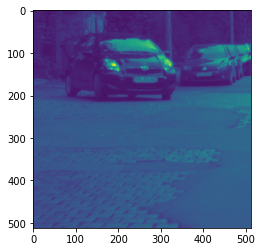

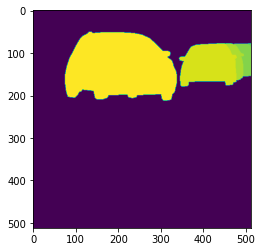

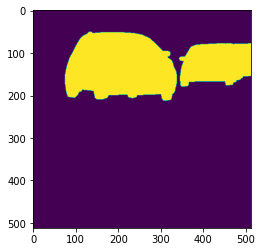

In [13]:
import matplotlib.pyplot as plt

i = 4

plt.imshow(im[i][2].numpy())
plt.show()
plt.imshow(instances[i].numpy())
plt.show()
plt.imshow(class_labels[i].numpy())
plt.show()

In [8]:
model = get_model(args['model']['name'], args['model']['kwargs'])
model = torch.nn.DataParallel(model).to(device)

state = torch.load('C:/Users/Moon/Desktop/SpatialEmbeddings-master/pretrained_models/cars_pretrained_model.pth')
model.load_state_dict(state['model_state_dict'])
model

Creating branched erfnet with [3, 1] classes


DataParallel(
  (module): BranchedERFNet(
    (encoder): Encoder(
      (initial_block): DownsamplerBlock(
        (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layers): ModuleList(
        (0): DownsamplerBlock(
          (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): non_bottleneck_1d(
          (conv3x1_1): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
          (conv1x3_1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
          (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=Tr

torch.Size([16, 4, 512, 512])


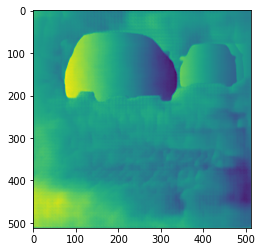

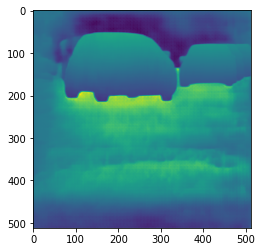

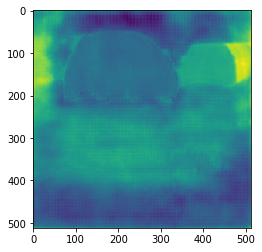

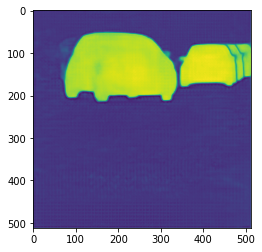

In [14]:
output = model(im)
print(output.shape)

plt.imshow(output[i][0].cpu().detach().numpy())
plt.show()
plt.imshow(output[i][1].cpu().detach().numpy())
plt.show()
plt.imshow(output[i][2].cpu().detach().numpy())
plt.show()
plt.imshow(output[i][3].cpu().detach().numpy())
plt.show()

In [15]:
instance = instances[i].unsqueeze(0)  # instance-mask (1, h, w)
label = class_labels[i].unsqueeze(0)  # semantic-mask (1, h, w)

instance_ids = instance.unique()
instance_ids = instance_ids[instance_ids != 0]

print(instance.shape)
print(label.shape)
print(instance_ids)

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
tensor([12, 13, 14, 15, 16], dtype=torch.uint8)


In [16]:
output.shape

torch.Size([16, 4, 512, 512])

In [21]:
xm = torch.linspace(0, 2, 2048).view(
    1, 1, -1).expand(1, 1024, 2048)  # x-coordinates are within [0, 2] : (1, h, w)
ym = torch.linspace(0, 1, 1024).view(
    1, -1, 1).expand(1, 1024, 2048)
xym = torch.cat((xm, ym), 0)

xym_s = xym[:, 0:512, 0:512].contiguous().cuda()

prediction = output  # 4 ch
height, width = 512, 512

n_sigma = 1

# instance branch
spatial_emb = prediction[i, 0:2] + xym_s.cuda()  # 1~2 ch (pixel offset vectors + coordinate map)
sigma = prediction[i, 2:2 + n_sigma]  # 3 ch

instance_map = torch.zeros(height, width).byte().cuda()
        
unique_instances = instance.unique()
unique_instances = unique_instances[unique_instances != 0]

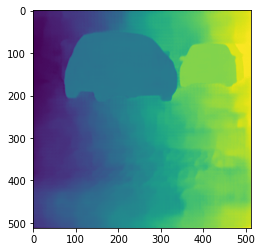

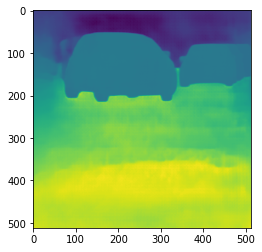

In [22]:
plt.imshow(spatial_emb[0].cpu().detach().numpy())
plt.show()
plt.imshow(spatial_emb[1].cpu().detach().numpy())
plt.show()

In [23]:
centers = []
dists = []
proposals = []

for id in unique_instances:
            
    # mask of each instance
    mask = instance.eq(id).view(1, height, width)  # (1, h, w)
    
    center = spatial_emb[mask.expand_as(spatial_emb)].view(
        2, -1).mean(1).view(2, 1, 1)  # 2 x 1 x 1
    
    s = sigma[mask.expand_as(sigma)].view(n_sigma, -1).mean(1).view(n_sigma, 1, 1)
    s = torch.exp(s*10)  # n_sigma x 1 x 1
            
    # calculate gaussian (distance of each pixel embedding from the center)
    # high value -> pixel embedding is close to the center
    dist = torch.exp(-1 * torch.sum(torch.pow(spatial_emb - center, 2)*s, 0))  # (h, w)
            
    # e.q (11)
    proposal = (dist > 0.5)  # (h, w)
    instance_map[proposal] = id  # (h, w)
    
    centers.append(center)
    dists.append(dist)
    proposals.append(proposal)

IndexError: list index out of range

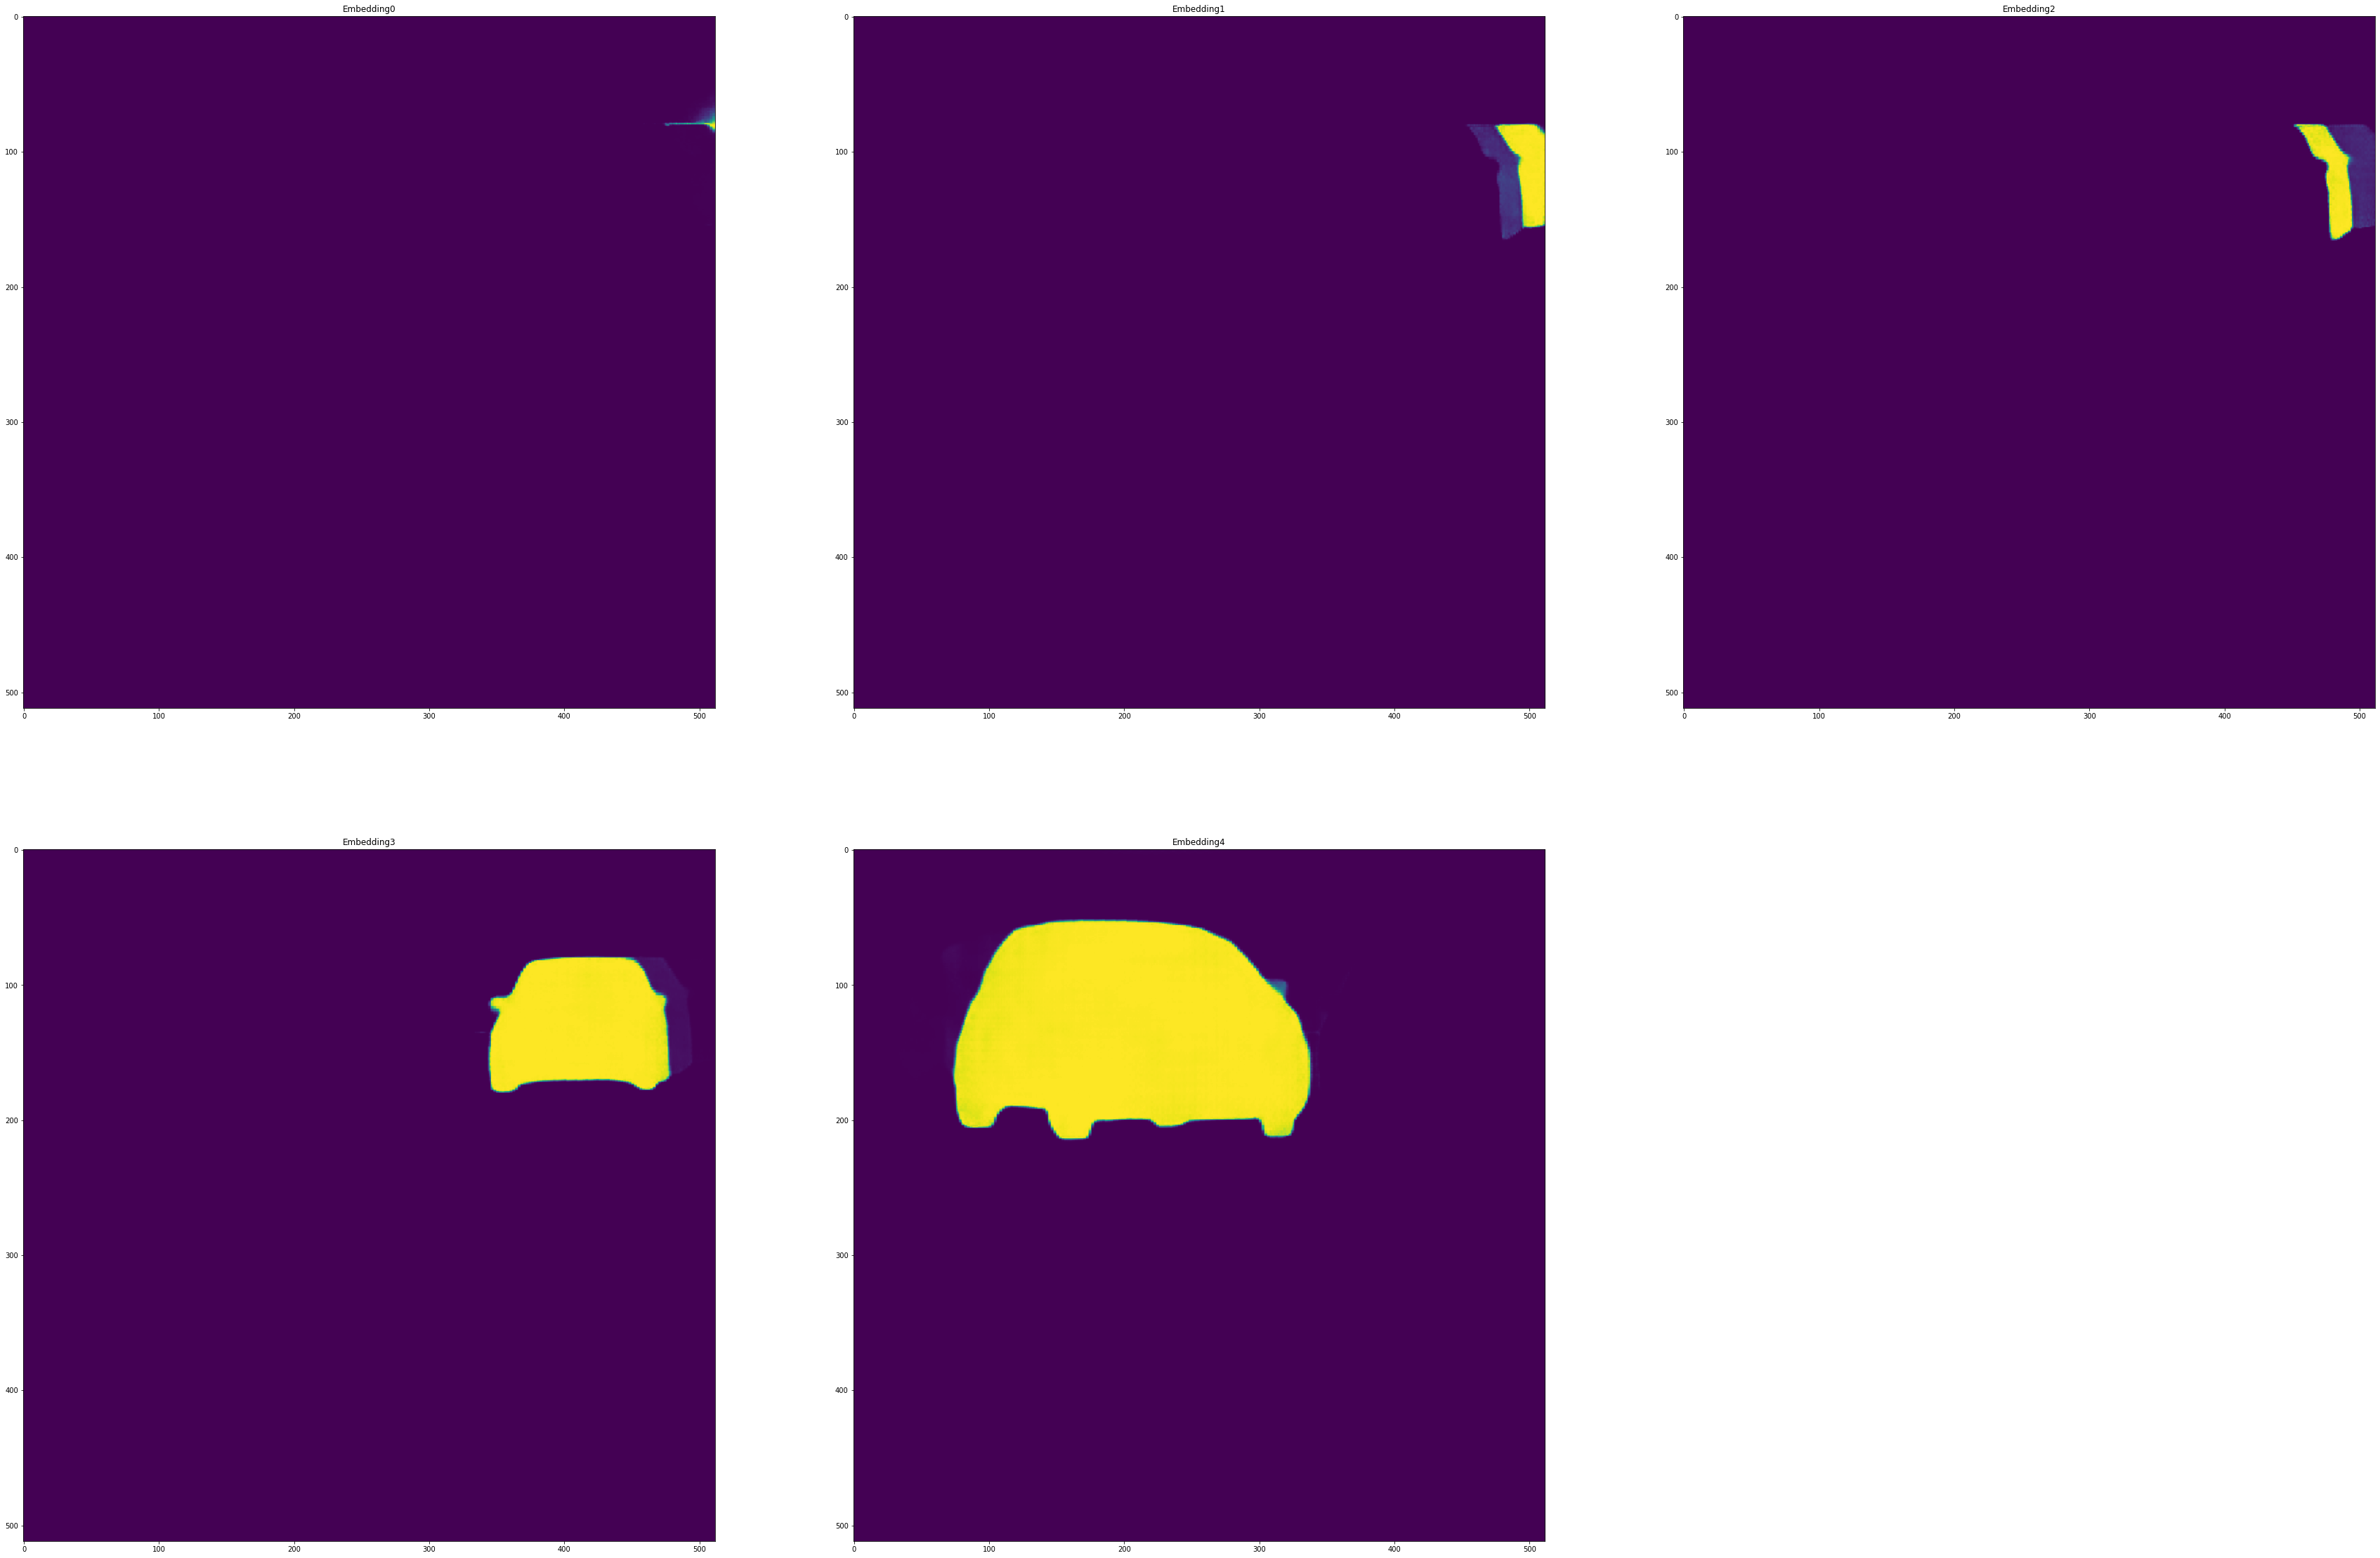

In [24]:
rows = 2
cols = 3
axes = []
fig = plt.figure(figsize=(60, 40))

for a in range(rows * cols):
    b = dists[a].cpu().detach()
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = ("Embedding" + str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    
fig.tight_layout()    
plt.show()

IndexError: list index out of range

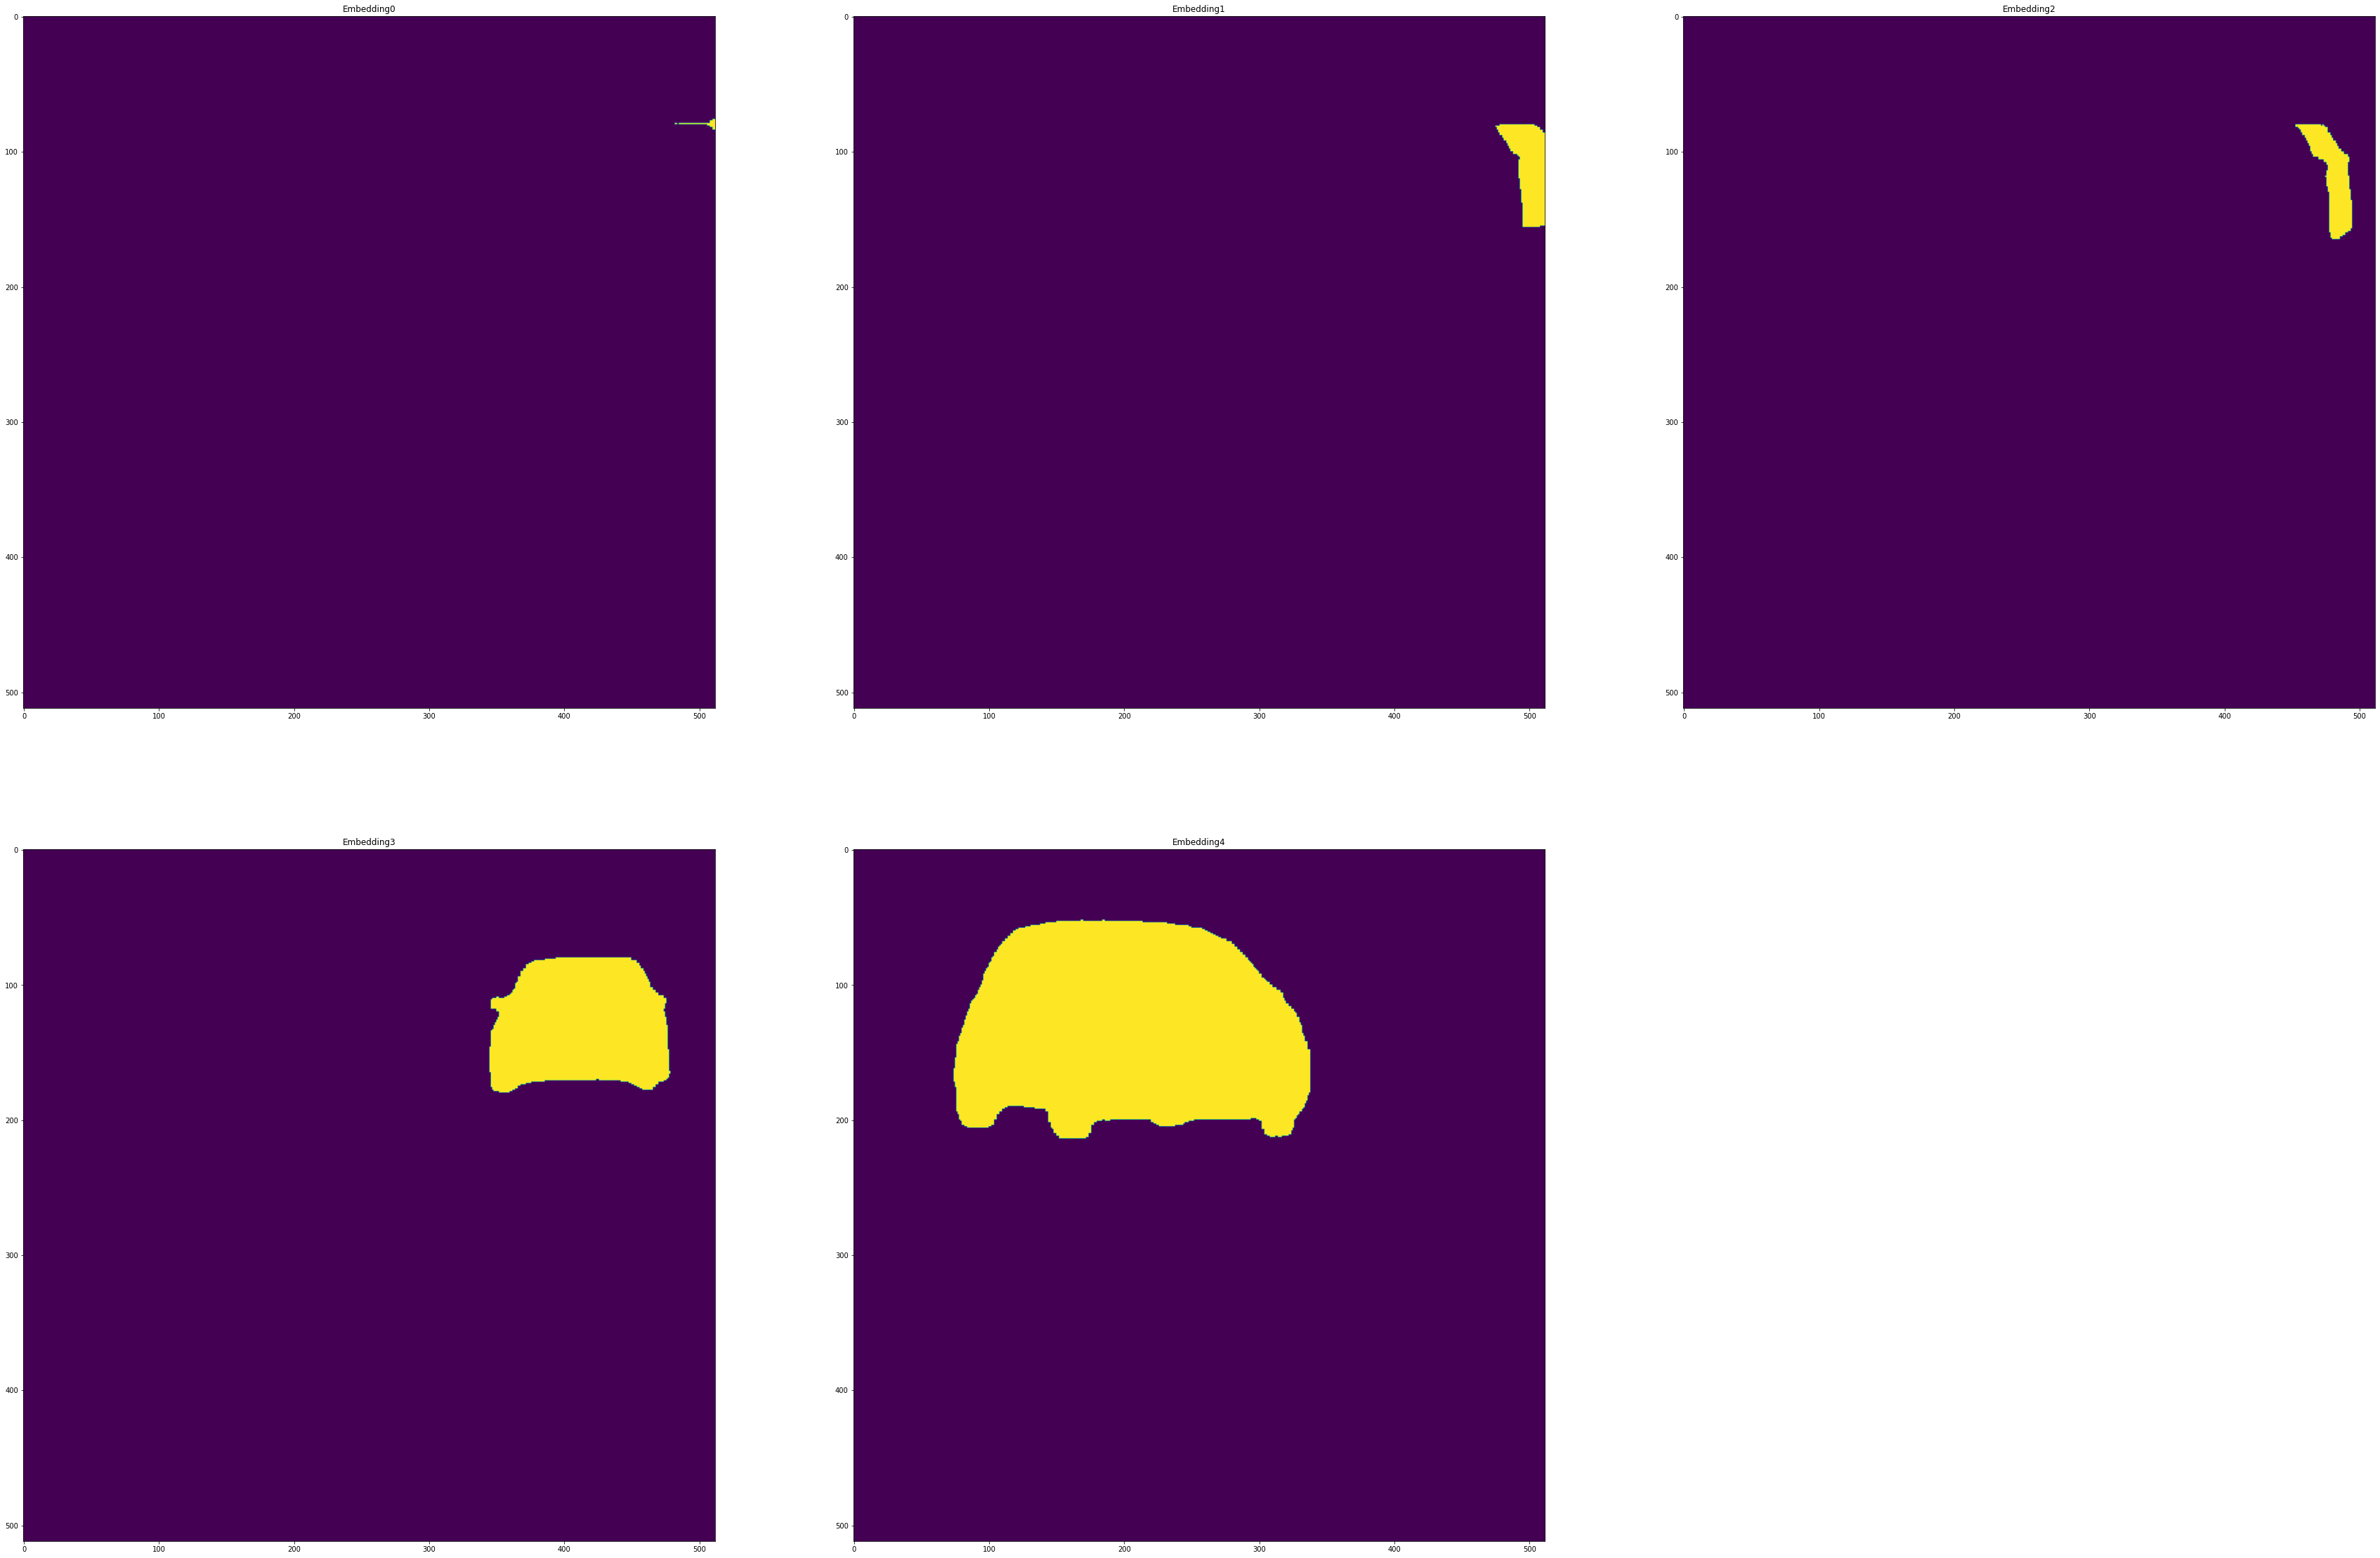

In [25]:
rows = 2
cols = 3
axes = []
fig = plt.figure(figsize=(60, 40))

for a in range(rows * cols):
    b = (proposals[a]*1).cpu().detach()
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = ("Embedding" + str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    
fig.tight_layout()    
plt.show()

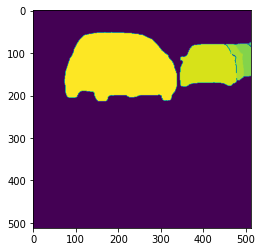

In [26]:
plt.imshow(instance_map.cpu().detach().numpy())
plt.show()